In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.applications import Xception, ResNet50, InceptionV3, MobileNet
import tensorflow.keras.utils as utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

from datetime import datetime


import cv2
import zipfile
import shutil
import os
import glob
import random

# Cats and Dogs CNN project (개와 고양이 구분하기)


# 1. 전이 학습 없이 학습시키기

## 1-1. Data Definition

In [2]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2023-07-26 06:04:48--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.215.128, 173.194.216.128, 173.194.217.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.215.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  78.0MB/s    in 0.8s    

2023-07-26 06:04:50 (78.0 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
with zipfile.ZipFile("/content/cats_and_dogs_filtered.zip", "r") as target_file:
  target_file.extractall("/content")

In [4]:
#### 데이터 갯수 확인

cats_train_list = os.listdir("/content/cats_and_dogs_filtered/train/cats")
dogs_train_list = os.listdir("/content/cats_and_dogs_filtered/train/dogs")

cats_val_list = os.listdir("/content/cats_and_dogs_filtered/validation/cats")
dogs_val_list = os.listdir("/content/cats_and_dogs_filtered/validation/dogs")

print(len(cats_train_list), len(dogs_train_list))
print(len(cats_val_list), len(dogs_val_list))

1000 1000
500 500


- 고양이와 강아지의 이미지 파일이 각각 train:1000장 / validation: 500장으로 이미지의 수가 부족해보임

### 1-1-1. train 디렉토리에서 X_train, y_train 생성

- 훈련용 데이터 준비해보자

In [5]:
DATA_ROOT_DIR = '/content/cats_and_dogs_filtered'

TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'train')
VAL_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'validation')

In [6]:
label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
label_name_list

['cats', 'dogs']

In [7]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

In [8]:
train_image_list = []
train_label_list = []

class_dict = {"cats" : 0, "dogs" : 1}

start_time = datetime.now()

for label_name in label_name_list:                             # label_name_list = [cats, dogs]
  file_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)    # 두 개의 경로를 하나의 경로로 이어줌.
  img_file_list = glob.glob(file_path + "/*.jpg")

  for img_file in img_file_list:                               # img_file_list = [cat사진들, dogs사진들]
    src_img = cv2.imread(img_file, cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=(IMG_WIDTH,IMG_HEIGHT))
    src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

    train_image_list.append(src_img)                           # X데이터
    train_label_list.append(float(class_dict[label_name]))     # y데이터

end_time = datetime.now()

print("걸린시간:", end_time - start_time)

걸린시간: 0:00:05.553330


In [9]:
X_train = np.array(train_image_list).astype('float32')
y_train = np.array(train_label_list).astype('float32')

In [ ]:
X_train

array([[[[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [241., 252., 248.],
         [239., 251., 247.],
         [233., 248., 243.]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [242., 253., 249.],
         [240., 253., 249.],
         [234., 249., 244.]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [244., 254., 251.],
         [241., 253., 249.],
         [237., 250., 246.]],

        ...,

        [[ 18.,  34.,  36.],
         [ 20.,  37.,  38.],
         [ 24.,  43.,  44.],
         ...,
         [ 96., 117., 119.],
         [ 89., 119., 121.],
         [ 54.,  88.,  89.]],

        [[ 18.,  19.,  23.],
         [ 17.,  18.,  22.],
         [ 17.,  21.,  24.],
         ...,
         [ 95., 116., 117.],
         [ 86., 117., 119.],
         [ 76., 109., 110.]],

        [[ 30.,  19.,  24.],
       

In [ ]:
y_train

array([0., 0., 0., ..., 1., 1., 1.], dtype=float32)

In [ ]:
print(X_train.shape, y_train.shape)

(2000, 224, 224, 3) (2000,)


### 1-1-2. validation 디렉토리에서 X_val, y_val 생성

In [10]:
val_image_list = []
val_label_list = []

class_dict = {"cats" : 0, "dogs" : 1}

start_time = datetime.now()

for label_name in label_name_list:                           # label_name_list = [cats, dogs]
  file_path = os.path.join(VAL_DATA_ROOT_DIR, label_name)    # 두 개의 경로를 하나의 경로로 이어줌.
  img_file_list = glob.glob(file_path + "/*.jpg")

  for img_file in img_file_list:
    src_img = cv2.imread(img_file, cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=(IMG_HEIGHT,IMG_WIDTH))
    src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

    val_image_list.append(src_img)                             # X데이터
    val_label_list.append(float(class_dict[label_name]))       # y데이터


end_time = datetime.now()

print("걸린시간:", end_time - start_time)

걸린시간: 0:00:02.371163


In [11]:
X_val = np.array(val_image_list).astype('float32')
y_val = np.array(val_label_list).astype('float32')

In [ ]:
X_val

array([[[[ 48.,  19.,   5.],
         [ 49.,  20.,   6.],
         [ 49.,  20.,   4.],
         ...,
         [  4.,   4.,   4.],
         [  5.,   5.,   5.],
         [  5.,   5.,   5.]],

        [[ 48.,  19.,   5.],
         [ 49.,  20.,   6.],
         [ 50.,  21.,   5.],
         ...,
         [  4.,   4.,   4.],
         [  7.,   7.,   7.],
         [  7.,   7.,   7.]],

        [[ 49.,  20.,   6.],
         [ 50.,  21.,   7.],
         [ 51.,  22.,   6.],
         ...,
         [  4.,   4.,   4.],
         [  4.,   4.,   4.],
         [  4.,   4.,   4.]],

        ...,

        [[164.,  53.,  66.],
         [194.,  41.,  71.],
         [204.,  90., 112.],
         ...,
         [ 29., 127., 208.],
         [ 29., 128., 215.],
         [ 31., 131., 219.]],

        [[189.,  99., 108.],
         [189.,  56.,  82.],
         [221., 124., 144.],
         ...,
         [ 35., 130., 212.],
         [ 28., 124., 211.],
         [ 29., 126., 215.]],

        [[213., 143., 148.],
       

In [ ]:
y_val

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
print(X_val.shape, y_val.shape)

(1000, 224, 224, 3) (1000,)


### 1-1-3. Validation으로부터 test data 분리 (분리 비율은 8:2)

In [12]:
len(X_val)                    # 고양이 사진 500장, 강아지 사진 500장.

1000

In [13]:
s = np.arange(len(X_val))     # s = [0,1,2,3,....,998,999]
np.random.shuffle(s)          # 인덱스를 셔플 ex) s = [51,49,0,5,992,....,37] 이런식으로 random하게 셔플되어 있는 상황

X_val = X_val[s]              # X_val 이 X_val[s] 로 바뀌고
y_val = y_val[s]              # X_val 에 해당되는 y_val도 할당됨.

split_num = int(0.2 * len(X_val))  # 이 상태에서 200개를 test로 보내려고 함.

X_test = X_val[0:split_num]
y_test = y_val[0:split_num]

X_val = X_val[split_num:]
y_val = y_val[split_num:]

In [14]:
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(800, 224, 224, 3) (800,)
(200, 224, 224, 3) (200,)


### 1-1-4. 이미지 데이터 정규화 및 전처리

In [15]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train.reshape(-1, 224, 224, 3)
X_test.reshape(-1,224, 224, 3)

array([[[[0.19607843, 0.3254902 , 0.36078432],
         [0.19607843, 0.3254902 , 0.36078432],
         [0.18431373, 0.3137255 , 0.34901962],
         ...,
         [0.01568628, 0.03529412, 0.03921569],
         [0.01960784, 0.03921569, 0.04313726],
         [0.01176471, 0.02745098, 0.03137255]],

        [[0.18431373, 0.30980393, 0.3529412 ],
         [0.20392157, 0.33333334, 0.37254903],
         [0.16862746, 0.29411766, 0.3372549 ],
         ...,
         [0.01568628, 0.03921569, 0.04313726],
         [0.01176471, 0.03137255, 0.03529412],
         [0.01176471, 0.02745098, 0.03137255]],

        [[0.19215687, 0.32156864, 0.37254903],
         [0.18431373, 0.30980393, 0.3647059 ],
         [0.18431373, 0.30980393, 0.3647059 ],
         ...,
         [0.01960784, 0.03921569, 0.04705882],
         [0.00784314, 0.02745098, 0.03137255],
         [0.01568628, 0.03137255, 0.03529412]],

        ...,

        [[0.14509805, 0.1882353 , 0.13333334],
         [0.14901961, 0.19215687, 0.13725491]

## 1-2. CNN 모델 구축

- C C P / C C P / C P / C P / F D D

In [ ]:
model = Sequential()

# 1st Convolution Layer
model.add(Conv2D(filters=32, kernel_size=3, padding="SAME", input_shape=(224,224,3), activation="relu"))
model.add(Conv2D(filters=32, kernel_size=3, padding="SAME", input_shape=(224,224,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2), padding="SAME"))
model.add(Dropout(0.25))

# 2nd Convolution Layer
model.add(Conv2D(filters=64, kernel_size=3, padding="SAME", input_shape=(224,224,3), activation="relu"))
model.add(Conv2D(filters=64, kernel_size=3, padding="SAME", input_shape=(224,224,3), activation="relu"))
model.add(MaxPool2D(padding="SAME"))
model.add(Dropout(0.25))

# 3rd Convolution Layer
model.add(Conv2D(filters=128, kernel_size=3, padding="SAME", input_shape=(224,224,3), activation="relu"))
model.add(MaxPool2D(padding="SAME"))
model.add(Dropout(0.25))

# 4th Convolution Layer
model.add(Conv2D(filters=256, kernel_size=3, padding="SAME", input_shape=(224,224,3), activation="relu"))
model.add(MaxPool2D(padding="SAME"))
model.add(Dropout(0.25))

# 입력층
model.add(GlobalAveragePooling2D())         # GlobalAveragePooling2D: 각 특성 맵의 평균 값을 뽑아 벡터로 만들어주기 때문에, Flatten이 필요없음.

# 은닉층
model.add(Dense(8, activation="relu"))
model.add(Dropout(0.5))

# 출력층
model.add(Dense(2, activation="softmax"))   # model.add(Dense(1, activation="sigmoid"))

# 활성화함수로 sigmoid를 썼다면, loss="binary_crossentropy"
model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
start_time = datetime.now()

result = model.fit(X_train, y_train, epochs=30, validation_data = (X_val,y_val), batch_size = 16)    # test 데이터는 마지막에 evaluate를 할 때 쓴다.

end_time = datetime.now()

model.evaluate(X_test, y_test)

print("걸린 시간:", end_time - start_time)

Epoch 1/30
125/125 [==============================] - 28s 95ms/step - loss: 0.6955 - accuracy: 0.4860 - val_loss: 0.6933 - val_accuracy: 0.4875
Epoch 2/30
125/125 [==============================] - 11s 86ms/step - loss: 0.6932 - accuracy: 0.4920 - val_loss: 0.6933 - val_accuracy: 0.4875
Epoch 3/30
125/125 [==============================] - 11s 87ms/step - loss: 0.6934 - accuracy: 0.4840 - val_loss: 0.6932 - val_accuracy: 0.4875
Epoch 4/30
125/125 [==============================] - 11s 91ms/step - loss: 0.6933 - accuracy: 0.4910 - val_loss: 0.6931 - val_accuracy: 0.5125
Epoch 5/30
125/125 [==============================] - 11s 87ms/step - loss: 0.6932 - accuracy: 0.4890 - val_loss: 0.6931 - val_accuracy: 0.5125
Epoch 6/30
125/125 [==============================] - 11s 92ms/step - loss: 0.6932 - accuracy: 0.5010 - val_loss: 0.6932 - val_accuracy: 0.4875
Epoch 7/30
125/125 [==============================] - 11s 88ms/step - loss: 0.6933 - accuracy: 0.4930 - val_loss: 0.6932 - val_accuracy:

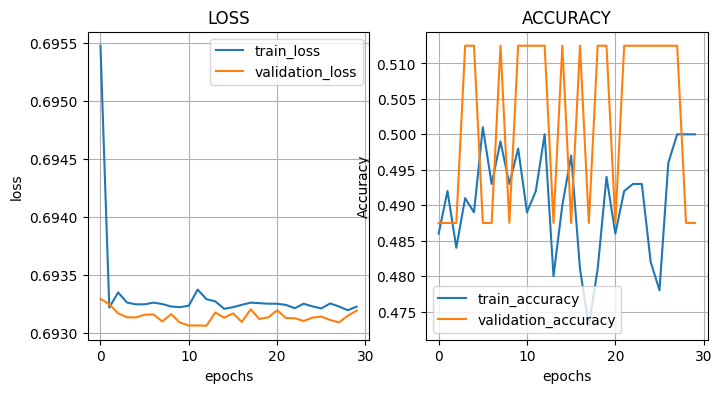

In [ ]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best")
# plt.show()

plt.subplot(1, 2, 2)

plt.title("ACCURACY")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.grid()

plt.plot(result.history["accuracy"], label="train_accuracy")
plt.plot(result.history["val_accuracy"], label="validation_accuracy")
plt.legend(loc="best")
plt.show()

## 1-3. 결과 시각화 및 해석

- 성능이 좋지 않은 이유는?
  - 데이터의 개수가 절대적으로 적음
  - CNN 설계를 얼마나 딥하게 해야하는지 알 수 없음.
----
- 이런 문제를 해결하는데 가장 효과적인 방법이 "전이학습"

# 2. 전이 학습의 개요

- ImageNet 처럼 아주 큰 데이터셋을 사용하여 사전 학습 모델(pre-trained model)의 가중치를 가져와 우리가 분석하려는 데이터에 맞게 보정해서 사용하는 것을 의미
- 사전 학습 모델은 특징 추출기와 분류기로 이루어져 있다.
- 파인 튜닝

----
- <추천모델>
  - InceptionV3, ResNet50, Xception, MobileNet
  - 내가 가진 데이터셋에 맞게 골라서 사용


In [ ]:
from tensorflow.keras.applications import Xception, ResNet50, InceptionV3, MobileNet

## 2-1) MobileNet

- MobileNet은 경량한 구조를 설계하는데 집중한 모델. 연산속도가 매우 빠름

- include_top = True : 네트워크 상단에 완전 연결층을 포함할지의 여부, include_top을 True로 설정했을 경우, 완전 연결층이 포함되기 때문에 FC계층을 만들어 줄 필요 없음.


In [ ]:
?MobileNet

- MobileNet의 인자 (
          input_shape=None, alpha=1.0, depth_multiplier=1,      
          dropout=0001, include_top=True, weights='imagenet',
          input_tensor=None, pooling=None, classes=1000, classifier_activation='softmax', **kwargs)

In [ ]:
DATA_ROOT_DIR = '/content/cats_and_dogs_filtered'

TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'train')
VAL_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'validation')

label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
label_name_list

IMG_WIDTH = 224
IMG_HEIGHT = 224


train_image_list = []
train_label_list = []

class_dict = {"cats" : 0, "dogs" : 1}

start_time = datetime.now()

for label_name in label_name_list:                             # label_name_list = [Positive, Negative]
  file_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)    # 두 개의 경로를 하나의 경로로 이어줌.
  img_file_list = glob.glob(file_path + "/*.jpg")

  for img_file in img_file_list:
    src_img = cv2.imread(img_file, cv2.IMREAD_COLOR) # 원본을 바꿔버림
    src_img = cv2.resize(src_img, dsize=(IMG_HEIGHT,IMG_WIDTH))
    src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

    train_image_list.append(src_img)               # X데이터
    train_label_list.append(float(class_dict[label_name]))       # y데이터

end_time = datetime.now()

print("걸린시간:", end_time - start_time)

X_train = np.array(train_image_list).astype('float32')
y_train = np.array(train_label_list).astype('float32')

val_image_list = []
val_label_list = []

class_dict = {"cats" : 0, "dogs" : 1}

start_time = datetime.now()

for label_name in label_name_list:                             # label_name_list = [Positive, Negative]
  file_path = os.path.join(VAL_DATA_ROOT_DIR, label_name)    # 두 개의 경로를 하나의 경로로 이어줌.
  img_file_list = glob.glob(file_path + "/*.jpg")

  for img_file in img_file_list:
    src_img = cv2.imread(img_file, cv2.IMREAD_COLOR) # 원본을 바꿔버림
    src_img = cv2.resize(src_img, dsize=(IMG_HEIGHT,IMG_WIDTH))
    src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

    val_image_list.append(src_img)                             # X데이터
    val_label_list.append(float(class_dict[label_name]))       # y데이터


end_time = datetime.now()

print("걸린시간:", end_time - start_time)

X_val = np.array(val_image_list).astype('float32')
y_val = np.array(val_label_list).astype('float32')


s = np.arange(len(X_val))
np.random.shuffle(s)          # 인덱스를 셔플해줘야 함.

X_val = X_val[s]
y_val = y_val[s]

split_num = int(0.2 * len(X_val))

X_test = X_val[0:split_num]
y_test = y_val[0:split_num]

X_val = X_val[split_num:]
y_val = y_val[split_num:]

X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train.reshape(-1, 224, 224, 3)
X_test.reshape(-1,224, 224, 3)

걸린시간: 0:00:05.592377
걸린시간: 0:00:04.179308


array([[[[0.3764706 , 0.32941177, 0.18039216],
         [0.3764706 , 0.32941177, 0.18039216],
         [0.3764706 , 0.32941177, 0.18039216],
         ...,
         [0.34117648, 0.28627452, 0.17254902],
         [0.34901962, 0.29411766, 0.18039216],
         [0.34901962, 0.29411766, 0.18039216]],

        [[0.3882353 , 0.34117648, 0.19215687],
         [0.38431373, 0.3372549 , 0.1882353 ],
         [0.3882353 , 0.34117648, 0.19215687],
         ...,
         [0.34117648, 0.28627452, 0.17254902],
         [0.34901962, 0.29411766, 0.18039216],
         [0.34901962, 0.29411766, 0.18039216]],

        [[0.40784314, 0.35686275, 0.21176471],
         [0.40784314, 0.36078432, 0.21176471],
         [0.40784314, 0.36078432, 0.21176471],
         ...,
         [0.34117648, 0.28627452, 0.17254902],
         [0.34901962, 0.29411766, 0.18039216],
         [0.34901962, 0.29411766, 0.18039216]],

        ...,

        [[0.21568628, 0.2       , 0.09411765],
         [0.20392157, 0.1882353 , 0.09019608]

In [ ]:
base_model = MobileNet(weights = "imagenet", include_top = True, input_shape=(224,224,3))
base_model.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32

In [ ]:
base_model.compile(loss="sparse_categorical_crossentropy", optimizer = Adam(learning_rate=0.0001), metrics=["accuracy"])

start_time = datetime.now()

result = base_model.fit(X_train, y_train, epochs=30, validation_data = (X_val,y_val), batch_size = 16)    # test 데이터는 마지막에 evaluate를 할 때 쓴다.

end_time = datetime.now()

Epoch 1/30
125/125 [==============================] - 31s 97ms/step - loss: 1.9943 - accuracy: 0.7400 - val_loss: 8.4935 - val_accuracy: 0.0625
Epoch 2/30
125/125 [==============================] - 11s 88ms/step - loss: 0.0849 - accuracy: 0.9790 - val_loss: 0.6059 - val_accuracy: 0.8813
Epoch 3/30
125/125 [==============================] - 11s 87ms/step - loss: 0.0891 - accuracy: 0.9805 - val_loss: 0.1328 - val_accuracy: 0.9762
Epoch 4/30
125/125 [==============================] - 11s 87ms/step - loss: 0.0370 - accuracy: 0.9920 - val_loss: 0.0787 - val_accuracy: 0.9800
Epoch 5/30
125/125 [==============================] - 11s 86ms/step - loss: 0.0282 - accuracy: 0.9915 - val_loss: 0.0514 - val_accuracy: 0.9862
Epoch 6/30
125/125 [==============================] - 11s 86ms/step - loss: 0.0170 - accuracy: 0.9945 - val_loss: 0.0913 - val_accuracy: 0.9800
Epoch 7/30
125/125 [==============================] - 11s 89ms/step - loss: 0.0215 - accuracy: 0.9955 - val_loss: 0.0952 - val_accuracy:

In [ ]:
base_model.evaluate(X_test, y_test)

print("걸린 시간:", end_time - start_time)

7/7 [==============================] - 2s 79ms/step - loss: 0.0541 - accuracy: 0.9750
걸린 시간: 0:06:30.721654


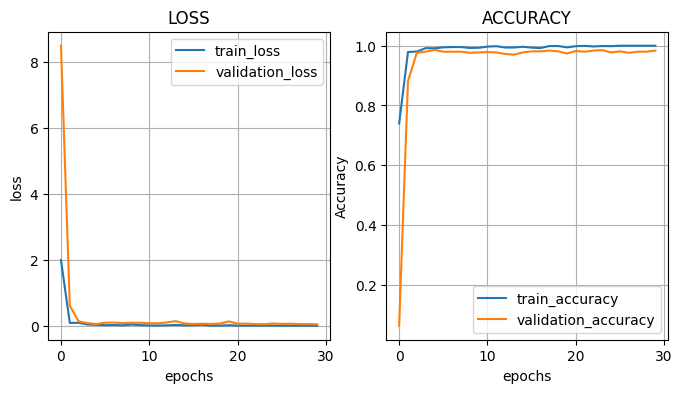

In [ ]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best")
# plt.show()

plt.subplot(1, 2, 2)

plt.title("ACCURACY")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.grid()

plt.plot(result.history["accuracy"], label="train_accuracy")
plt.plot(result.history["val_accuracy"], label="validation_accuracy")
plt.legend(loc="best")
plt.show()

### 2-1-1. MobileNet의 오답노트 만들기

In [ ]:
ret_val = model.predict(X_test)

7/7 [==============================] - 0s 38ms/step


In [ ]:
pred_val = np.argmax(ret_val, axis=1)
pred_val

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [ ]:
pred_comp_val = np.equal(pred_val, y_test)
pred_comp_val

array([False,  True, False, False,  True, False,  True, False, False,
       False,  True,  True,  True, False, False,  True,  True,  True,
        True, False, False, False,  True, False, False,  True, False,
        True, False,  True,  True,  True, False,  True,  True,  True,
       False,  True, False,  True,  True,  True, False, False,  True,
        True,  True, False,  True, False, False, False, False, False,
       False,  True, False,  True, False, False,  True, False,  True,
       False, False, False, False, False,  True, False, False, False,
        True,  True, False, False,  True, False, False,  True, False,
        True, False,  True, False, False,  True,  True, False,  True,
        True,  True, False, False, False,  True, False,  True, False,
       False,  True,  True,  True,  True,  True,  True, False, False,
        True, False,  True,  True, False, False, False, False, False,
        True,  True,  True, False, False,  True,  True, False,  True,
       False, False,

잘못 예측한 사진의 갯수:  107


(-0.5, 223.5, 223.5, -0.5)

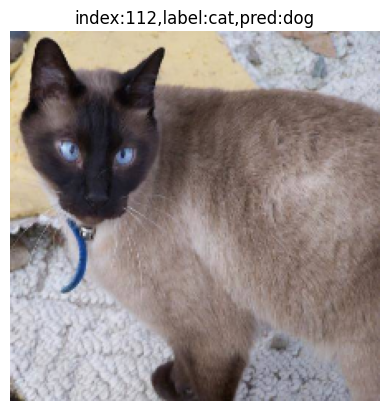

In [ ]:
index_label_pred_list = [[idx, y_test[idx], pred_val[idx]] for idx, result in enumerate(pred_comp_val) if result == False]

print("잘못 예측한 사진의 갯수: ", len(index_label_pred_list))

false_data_index = np.random.randint(len(index_label_pred_list))

index = index_label_pred_list[false_data_index][0]    # 인덱스
label = index_label_pred_list[false_data_index][1]          # 정답
pred = index_label_pred_list[false_data_index][2]

img = X_test[index]

class_ = {0: 'cat', 1:'dog'}

title = "index:" + str(index) + "," + "label:" + class_[label] + "," + "pred:" + class_[pred]
plt.title(title)
plt.imshow(img)
plt.axis("off")

## 2-2) InceptionV3

- Total params: 21,802,784 으로 MobileNet에 비해 사용된 parms이 많음.
- 높은 정확도를 위해 많은 params를 사용한 것.
- include_top = False 일 경우, FC계층은 내가 만들어줘야 함.
  - base_model = InceptionV3()
  - model = Sequential()
  - model.add(base_model)로 특성 추출기를, 분류기에 추가해준다.

In [ ]:
#### 데이터 갯수 확인
DATA_ROOT_DIR = '/content/cats_and_dogs_filtered'

TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'train')
VAL_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'validation')

label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
label_name_list

IMG_WIDTH = 299            # inceptionV3의 디폴트는 299*299 지만, include_top=False로 썼기 때문에 내가 원하는 값을 입력해줘도 됨.
IMG_HEIGHT = 299


train_image_list = []
train_label_list = []

class_dict = {"cats" : 0, "dogs" : 1}

start_time = datetime.now()

for label_name in label_name_list:                             # label_name_list = [Positive, Negative]
  file_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)    # 두 개의 경로를 하나의 경로로 이어줌.
  img_file_list = glob.glob(file_path + "/*.jpg")

  for img_file in img_file_list:
    src_img = cv2.imread(img_file, cv2.IMREAD_COLOR) # 원본을 바꿔버림
    src_img = cv2.resize(src_img, dsize=(IMG_HEIGHT,IMG_WIDTH))
    src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

    train_image_list.append(src_img)               # X데이터
    train_label_list.append(float(class_dict[label_name]))       # y데이터

end_time = datetime.now()

print("걸린시간:", end_time - start_time)

X_train = np.array(train_image_list).astype('float32')
y_train = np.array(train_label_list).astype('float32')

val_image_list = []
val_label_list = []

class_dict = {"cats" : 0, "dogs" : 1}

start_time = datetime.now()

for label_name in label_name_list:                             # label_name_list = [Positive, Negative]
  file_path = os.path.join(VAL_DATA_ROOT_DIR, label_name)    # 두 개의 경로를 하나의 경로로 이어줌.
  img_file_list = glob.glob(file_path + "/*.jpg")

  for img_file in img_file_list:
    src_img = cv2.imread(img_file, cv2.IMREAD_COLOR) # 원본을 바꿔버림
    src_img = cv2.resize(src_img, dsize=(IMG_HEIGHT,IMG_WIDTH))
    src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

    val_image_list.append(src_img)                             # X데이터
    val_label_list.append(float(class_dict[label_name]))       # y데이터


end_time = datetime.now()

print("걸린시간:", end_time - start_time)

X_val = np.array(val_image_list).astype('float32')
y_val = np.array(val_label_list).astype('float32')


s = np.arange(len(X_val))
np.random.shuffle(s)          # 인덱스를 셔플해줘야 함.

X_val = X_val[s]
y_val = y_val[s]

split_num = int(0.2 * len(X_val))

X_test = X_val[0:split_num]
y_test = y_val[0:split_num]

X_val = X_val[split_num:]
y_val = y_val[split_num:]

X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

base_model = InceptionV3(weights = "imagenet", include_top = False, input_shape=(224,224,3))  # include_top 을 false로 하면, CNN 특징 추출기만 가져오고, 학습할 때는 내가 만든 분류기를 사용할 수 있음.
base_model.summary()

# 내가 만든 학습기
model = Sequential()   # Fc계층 만들어주기

model.add(base_model)
model.add(Flatten())
model.add(Dense(16, activation="relu"))  # 은닉층
model.add(Dropout(0.25))

model.add(Dense(2, activation='softmax'))

model.compile(loss="sparse_categorical_crossentropy", optimizer = Adam(learning_rate=2e-5), metrics=["accuracy"])

start_time = datetime.now()

result = model.fit(X_train, y_train, epochs=30, validation_data = (X_val,y_val), batch_size = 16)    # test 데이터는 마지막에 evaluate를 할 때 쓴다.

end_time = datetime.now()

model.evaluate(X_test, y_test)

--2023-07-25 07:31:25--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip.1’

cats_and_dogs_filte 100%[===================>]  65.43M   172MB/s    in 0.4s    

2023-07-25 07:31:25 (172 MB/s) - ‘cats_and_dogs_filtered.zip.1’ saved [68606236/68606236]

1000 1000
500 500
걸린시간: 0:00:04.166917
걸린시간: 0:00:03.121338
87910968/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 22

[0.0998195931315422, 0.9649999737739563]

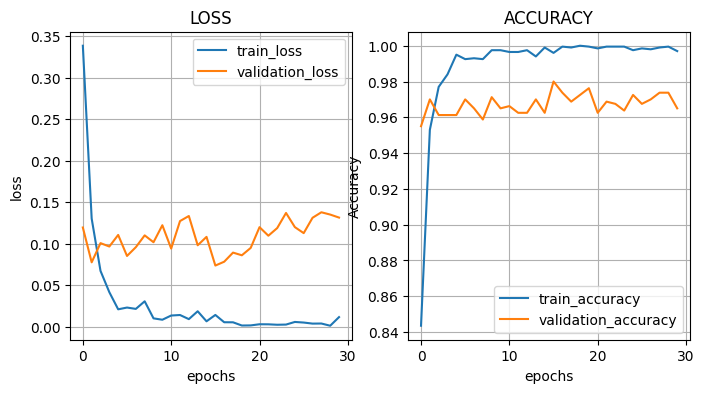

In [ ]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best")
# plt.show()

plt.subplot(1, 2, 2)

plt.title("ACCURACY")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.grid()

plt.plot(result.history["accuracy"], label="train_accuracy")
plt.plot(result.history["val_accuracy"], label="validation_accuracy")
plt.legend(loc="best")
plt.show()

- 전이학습 모델은 model.summary() 에 보면 학습하지 않은(Non-trainable param )변수들이 있음

- 미세 조정(fine-tuning): 전이학습에서는 사전에 훈련된 모델의 일부 층을 동결하고 일부 층만 추가로 훈련함.
- 동결된 층은 사전에 훈련된 가중치를 고정시켜 업데이트되지 않도록 하기 때문에 해당 층의 파라미터는 훈련되지 않는다. 따라서 Non-trainable params이 발생

- 파인 튜닝이 필요한 이유: 강아지/고양이는 구분하지만, 강아지 범주 안에서 디테일하게 종의 차이를 분류하기 위해


## 2-3) Fine Tunning

- ## 차이점

- include_top = True
    - 예측값까지 나옴(벡터)
    - prediction
    
- include_top = False
    - Conv (CNN)
    - ReLU

In [ ]:
##### 데이터 갯수 확인

cats_train_list = os.listdir("content/cats_and_dogs_filtered/train/cats")
dogs_train_list = os.listdir("content/cats_and_dogs_filtered/train/dogs")

cats_val_list = os.listdir("content/cats_and_dogs_filtered/validation/cats")
dogs_val_list = os.listdir("content/cats_and_dogs_filtered/validation/dogs")

print(len(cats_train_list), len(dogs_train_list))
print(len(cats_val_list), len(dogs_val_list))

### train디렉토리에서 X_train, y_train 생성

image_list = []
label_list = []

IMAGE_HEIGHT = 75
IMAGE_WIDTH = 75


train_base_dir = "content/cats_and_dogs_filtered/train"
train_label_list = os.listdir(train_base_dir)

start_time = datetime.now()

for train_label_name in train_label_list:
    if train_label_name == "cats":
        label_num = 0.0
    else:
        label_num = 1.0

    file_path = os.path.join(train_base_dir, train_label_name)
    img_file_list = glob(file_path + "/*.jpg")

    for img_file in img_file_list:
        src_img = cv2.imread(img_file, cv2.IMREAD_COLOR)
        src_img = cv2.resize(src_img, dsize=(IMAGE_WIDTH, IMAGE_HEIGHT))
        src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

        image_list.append(src_img)
        label_list.append(label_num)

end_time = datetime.now()
print("\n걸린시간 : ", end_time - start_time)

X_train = np.array(image_list).astype("float32")
y_train = np.array(label_list).astype("float32")

print(X_train.shape, y_train.shape)

### validation디렉토리에서 X_val, y_val 생성

image_list = []
label_list = []


val_base_dir = "content/cats_and_dogs_filtered/validation"
val_label_list = os.listdir(train_base_dir)

start_time = datetime.now()

for val_label_name in val_label_list:
    if val_label_name == "cats":
        label_num = 0.0
    else:
        label_num = 1.0

    file_path = os.path.join(val_base_dir, val_label_name)
    img_file_list = glob(file_path + "/*.jpg")

    for img_file in img_file_list:
        src_img = cv2.imread(img_file, cv2.IMREAD_COLOR)
        src_img = cv2.resize(src_img, dsize=(IMAGE_WIDTH, IMAGE_HEIGHT))
        src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

        image_list.append(src_img)
        label_list.append(label_num)

end_time = datetime.now()
print("\n걸린시간 : ", end_time - start_time)

X_val = np.array(image_list).astype("float32")
y_val = np.array(label_list).astype("float32")

print(X_val.shape, y_val.shape)

### validation으로부터 test data 분리( 분리 비율은 5 : 5)

s = np.arange(len(X_val))
np.random.shuffle(s)

X_val = X_val[s]
y_val = y_val[s]

split_num = int(0.5 * len(X_val))

X_test = X_val[0:split_num]
y_test = y_val[0:split_num]

X_val = X_val[split_num:]
y_val = y_val[split_num:]

print(X_val.shape, X_test.shape)
print(y_val.shape, y_test.shape)

### 이미지 데이터 정규화

X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0


base_model = MobileNet(weights='imagenet',
                       include_top=False,
                       input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)) # include_top 모델에 분류기 학습기 같이 가져옴. false는 학습기는 안가져온다. 따로 추가 필요.
base_model.summary()

model = Sequential()  # Fc계층 만들어주기

model.add(base_model)
model.add(Flatten())
model.add(Dense(16, activation="relu"))  # 은닉층
model.add(Dropout(0.25))

model.add(Dense(2, activation='softmax'))



model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

start_time = datetime.now()

result = model.fit(X_train, y_train,
                 epochs=3, batch_size=32,
                 validation_data=(X_val, y_val))

end_time = datetime.now()


model.evaluate(X_test, y_test)

In [ ]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best")
# plt.show()

plt.subplot(1, 2, 2)

plt.title("acc")
plt.xlabel("epochs")
plt.ylabel("acc")
plt.grid()

plt.plot(result.history["accuracy"], label="train_acc")
plt.plot(result.history["val_accuracy"], label="validation_acc")
plt.legend(loc="best")
plt.show()

## 2-4. ImageDataGenerator 사용

- 텐서플로우에서 이미지 데이터 보강을 위해 ImageDataGenerator 제공
- 원본 이미지에 적절한 변형을 가해서 새로운 데이터를 만드는 방식
- 데이터가 부족할 때 사용


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# rotation_range: 이미지 회전 범위를 지정. rotation_range=10은 이미지를 최대 10도까지 무작위로 회전시킬 수 있음을 의미
# shear_range: 이미지 전단 변형 범위를 지정. shear_range=0.2는 이미지를 최대 20%까지 무작위로 전단 변형시킬 수 있음을 의미
# horizontal_flip: 이미지를 수평으로 무작위로 뒤집을지 여부를 결정. True로 설정하면 이미지가 50%의 확률로 수평으로 뒤집힐 수 있음을 의미
# rescale: 이미지의 픽셀 값을 재조정하기 위한 값. 1./255로 설정하면 이미지의 픽셀 값을 0과 1 사이로 재조정.
# height_shift_range: 그림을 수직으로 랜덤하게 평행 이동시키는 범위. 이 값이 0.1 이면 전체 높이가 100일 경우, 10픽셀 내외로 이미지를 상하 이동
# width_shift_fange: 그림을 수평으로 랜덤하게 평행 이동시키는 범위. 이 값이 0.1 이면 전체 너비가 100일 경우, 10픽셀 내외로 이미지를 좌우 이동

### 2-4-1. [이진분류] Dense가 sigmoid , class_mode= "sparse" or "binary"

- class_mode = "sparse"는 다중 클래스 분류에는 적용되지 않음
---
- class_mode = "sparse"는 이진 분류나 다중 레이블 이진 분류에 사용
- class_mode = "sparse"는  클래스 라벨이 정수 형태로 주어질 때 사용

In [ ]:
IMAGE_WIDTH = 224
IMAGE_HEIGTH = 224

In [ ]:
# 데이터의 전처리를 위해 ImageDataGenerator 사용
train_data_gen = ImageDataGenerator(rotation_range=10, shear_range =0.2, horizontal_flip=True, rescale = 1./255, width_shift_range=0.1,
                                    height_shift_range=0.1, zoom_range=0.1)

valid_data_gen = ImageDataGenerator(rotation_range=10, shear_range =0.2, horizontal_flip=True, rescale = 1./255, width_shift_range=0.1,
                                   height_shift_range=0.1, zoom_range=0.1)

In [ ]:
# TRAIN_DATA_ROOT_DIR = '/content/cats_and_dogs_filtered/train'
# VAL_DATA_ROOT_DIR = '/content/cats_and_dogs_filtered/validation'

train_generator = train_data_gen.flow_from_directory(TRAIN_DATA_ROOT_DIR, target_size=(IMAGE_WIDTH, IMAGE_HEIGTH), batch_size = 16,
                                                     class_mode="sparse") # 클래스 라벨이 정수 형태로 주어질 때 사용

valid_generator = valid_data_gen.flow_from_directory(VAL_DATA_ROOT_DIR, target_size = (IMAGE_WIDTH, IMAGE_HEIGTH), batch_size = 16,
                                                     class_mode="sparse")

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
print(train_generator.class_indices)    # class_indicies -> 클래스 지표
print(train_generator.num_classes)      # num_classes    -> 클래스 갯수

print(valid_generator.class_indices)
print(valid_generator.num_classes)

{'cats': 0, 'dogs': 1}
2
{'cats': 0, 'dogs': 1}
2


In [ ]:
base_model = MobileNet(weights = "imagenet", include_top = False, input_shape=(IMAGE_WIDTH,IMAGE_HEIGTH,3))  # include_top 을 false로 하면, CNN 특징 추출기만 가져오고, 학습할 때는 내가 만든 분류기를 사용할 수 있음.
base_model.summary()

# 내가 만든 학습기
model = Sequential()  # Fc계층 만들어주기

model.add(base_model)
model.add(Flatten())
model.add(Dense(16, activation="relu"))  # 은닉층
model.add(Dropout(0.25))

model.add(Dense(1, activation='sigmoid')) # 이진분류

model.compile(loss="binary_crossentropy", optimizer = Adam(learning_rate=1e-4), metrics=["accuracy"])

start_time = datetime.now()

result = model.fit(train_generator, epochs=3, validation_data = valid_generator, batch_size = 16)    # imageDatagenerator이 알아서 해주기 때문에, y_train, y_test가 필요 없음.

end_time = datetime.now()


print("걸린 시간: ", end_time - start_time)
print(model.evaluate(valid_generator))

17225924/17225924 [==============================] - 2s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32

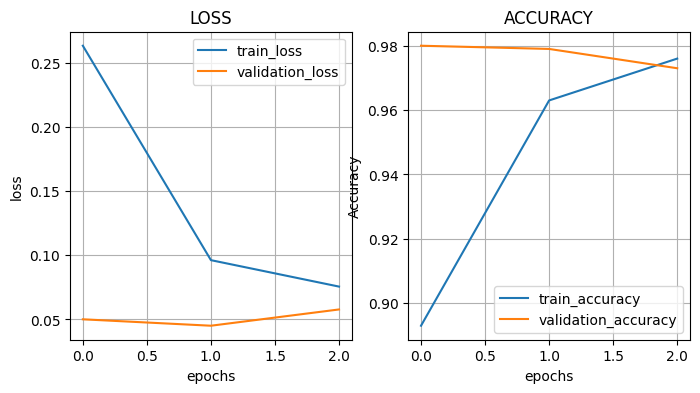

In [ ]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best")
# plt.show()

plt.subplot(1, 2, 2)

plt.title("ACCURACY")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.grid()

plt.plot(result.history["accuracy"], label="train_accuracy")
plt.plot(result.history["val_accuracy"], label="validation_accuracy")
plt.legend(loc="best")
plt.show()

In [ ]:
# 예측을 위해 임의의 강아지, 고양이 사진 인터넷에서 다운 받기.

test_img_list = []

test_img_name_list = glob.glob("/content/test_img/*")

for i in range(len(test_img_name_list)):
  src_img = cv2.imread(test_img_name_list[i], cv2.IMREAD_COLOR)
  src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
  dst_img = cv2.resize(src_img, dsize = [IMAGE_WIDTH, IMAGE_HEIGTH])
  dst_img = dst_img / 255.0

  test_img_list.append(dst_img)

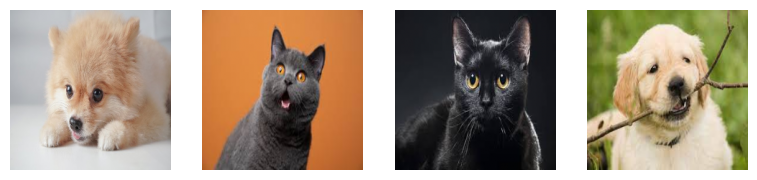

In [ ]:
plt.figure(figsize=(12,8))

for i in range(len(test_img_list)):
  plt.subplot(1, 5, i+1)
  plt.axis("off")
  plt.imshow(test_img_list[i])

In [ ]:
pred = model.predict(np.array(test_img_list))

1/1 [==============================] - 2s 2s/step


In [ ]:
train_generator.class_indices

{'cats': 0, 'dogs': 1}

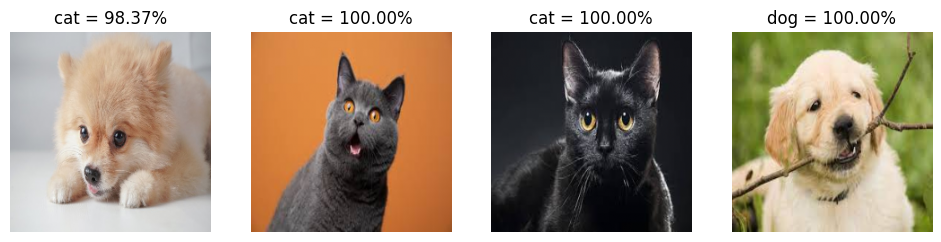

In [ ]:
plt.figure(figsize=(15, 10))

# 이진 분류 일 때
for i in range(len(pred)):
    if pred[i] > 0.5:
        prob = pred[i]
        prediction = 'dog'
    if pred[i] < 0.5:
        prob = 1 - pred[i]
        prediction = 'cat'


    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.imshow(test_img_list[i])
    prob_str=str("{0:0.2f}".format(100*max(prob)))+ "%"
    plt.title(prediction + " = " + prob_str)

    #plt.tight_layout()

### 2-4-2. [다중분류] Dense가 softmax, class_mode = "categorical"

In [ ]:
IMAGE_WIDTH = 224
IMAGE_HEIGTH = 224

#ImageDataGenerator로 이미지 증강
train_data_gen = ImageDataGenerator(rotation_range=10, shear_range =0.2, horizontal_flip=True,
                                    rescale = 1./255, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1)

valid_data_gen = ImageDataGenerator(rotation_range=10, shear_range =0.2, horizontal_flip=True,
                                   rescale = 1./255, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1)

# 폴더 구조를 그대로 가져와 ImageDataGenerator에 실제 데이터 채워주기
train_generator = train_data_gen.flow_from_directory(directory = TRAIN_DATA_ROOT_DIR, batch_size=4, shuffle = True, target_size = (IMAGE_WIDTH ,IMAGE_HEIGTH),
                        class_mode = "categorical")

val_generator = valid_data_gen.flow_from_directory(directory = VAL_DATA_ROOT_DIR, batch_size=4, shuffle = True, target_size = (IMAGE_WIDTH ,IMAGE_HEIGTH),
                        class_mode = "categorical")

print(train_generator.class_indices)
print(train_generator.num_classes)

print(val_generator.class_indices)
print(val_generator.num_classes)

# 특징 분류기만 MobileNet
base_model = MobileNet(weights="imagenet", include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGTH, 3))
base_model.summary()

# include_top = False이기 때문에, FC계층은 내가 설정
model= Sequential()

model.add(base_model)
model.add(Flatten())

model.add(Dense(16, activation="relu"))  # 은닉층
model.add(Dropout(0.25))

# 출력층
model.add(Dense(2, activation='softmax'))

model.compile(loss="categorical_crossentropy", optimizer = Adam(learning_rate = 1e-4), metrics=['accuracy'])

start_time = datetime.now()

result = model.fit(train_generator, epochs=3, validation_data=val_generator, batch_size=16)

end_time = datetime.now()

print("걸린 시간: ", end_time - start_time)
print(model.evaluate(val_generator))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
{'cats': 0, 'dogs': 1}
2
{'cats': 0, 'dogs': 1}
2
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                              

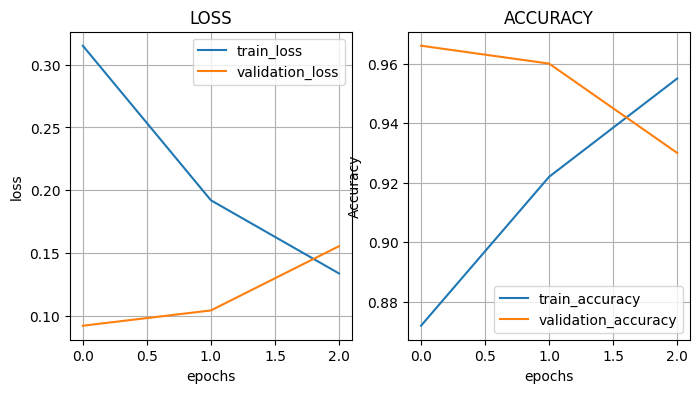

In [ ]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best")
# plt.show()

plt.subplot(1, 2, 2)

plt.title("ACCURACY")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.grid()

plt.plot(result.history["accuracy"], label="train_accuracy")
plt.plot(result.history["val_accuracy"], label="validation_accuracy")
plt.legend(loc="best")
plt.show()

In [ ]:
pred = model.predict(np.array(test_img_list))

1/1 [==============================] - 0s 409ms/step


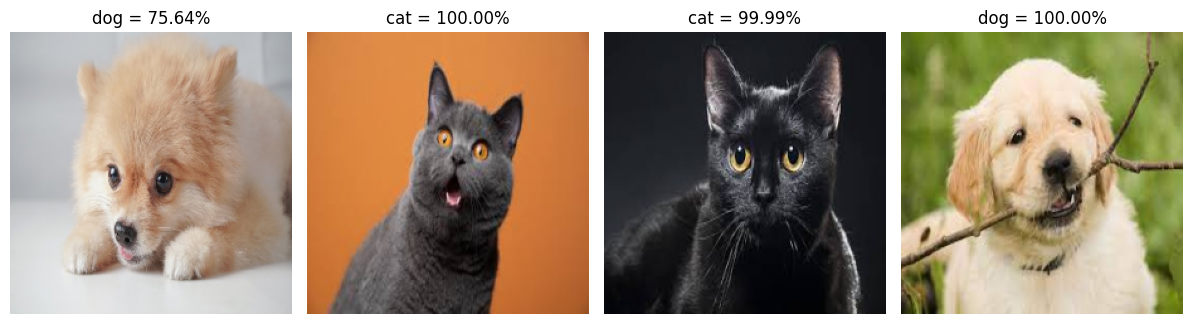

In [ ]:
## softmax 일 때는 시각화 방법이 다름

plt.figure(figsize=(15, 15))

class_name = ["cat", "dog"]   # softmax일 때

for i in range(len(pred)):
  plt.subplot(1, 5, i+1)
  plt.axis('off')

  prediction = class_name[np.argmax(pred[i])]             # softmax일 때는 모든 레이블에 대한 예측 확률이 나오기 때문에 np.argmax를 사용

  prob_str=str("{0:0.2f}".format(100*max(pred[i])))+ "%"
  plt.title(prediction + " = " +
            prob_str)
  plt.imshow(test_img_list[i])



### 2-4-3. ImageDataGenerator 에서 Validation Split

In [19]:
IMAGE_WIDTH = 224
IMAGE_HEIGTH = 224

# Imagedatagenerator
train_data_gen = ImageDataGenerator(rotation_range=10, shear_range =0.2, horizontal_flip=True, rescale = 1./255, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1,
                                    validation_split=0.2) # 최소 20%

valid_data_gen = ImageDataGenerator(rescale = 1. / 255.0, validation_split = 0.2)  # 훈련용에서 20%를 썼기 때문에 똑같이 써준다.

test_data_gen = ImageDataGenerator(rescale = 1./255)


# Flow from directory
train_generator = train_data_gen.flow_from_directory(directory = TRAIN_DATA_ROOT_DIR, batch_size=32, shuffle = True,
                                                     target_size = (IMAGE_WIDTH ,IMAGE_HEIGTH),
                                                     class_mode = "binary", subset = "training")   # 훈련용 -> subset = "training"

### train 데이터에서 20% 분할할 것이기 때문에, directory는 Train과 동일하게 적어줌.
val_generator = valid_data_gen.flow_from_directory(directory = TRAIN_DATA_ROOT_DIR, batch_size=32, shuffle = True,
                                                     target_size = (IMAGE_WIDTH ,IMAGE_HEIGTH),
                                                     class_mode = "binary", subset = "training")

test_generator = test_data_gen.flow_from_directory(directory = VAL_DATA_ROOT_DIR, batch_size=32, shuffle = True,
                                                     target_size = (IMAGE_WIDTH ,IMAGE_HEIGTH),
                                                     class_mode = "binary")


print(train_generator.class_indices)
print(train_generator.num_classes)

# 분류기
base_model = MobileNet(weights = "imagenet", include_top = False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGTH,3))
base_model.summary()

# include-top = False 내가 만든 학습기
model = Sequential()

model.add(base_model)
model.add(Flatten())

model.add(Dense(16, activation = "relu"))
model.add(Dropout(0.25))

model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer = Adam(learning_rate=1e-4), metrics=['accuracy'])

start_time = datetime.now()

result = model.fit(train_generator, epochs=3, validation_data= val_generator, batch_size=16)

end_time = datetime.now()

print("걸린 시간: ", end_time - start_time)

print(model.evaluate(test_generator))


Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
{'cats': 0, 'dogs': 1}
2
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                             

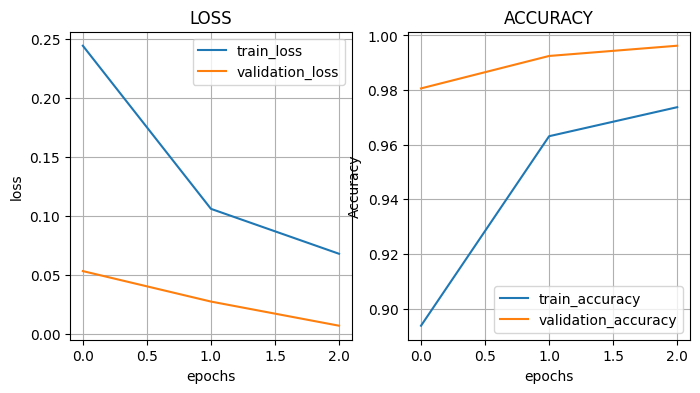

In [20]:
plt.figure(figsize=(8,4))

plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best")
# plt.show()

plt.subplot(1, 2, 2)

plt.title("ACCURACY")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.grid()

plt.plot(result.history["accuracy"], label="train_accuracy")
plt.plot(result.history["val_accuracy"], label="validation_accuracy")
plt.legend(loc="best")
plt.show()

In [31]:
test_img_list = []
test_img_name_list = glob.glob("/content/test_img/*")

for i in range(len(test_img_name_list)):
  src_img = cv2.imread(test_img_name_list[i], cv2.IMREAD_COLOR)
  src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
  dst_img = cv2.resize(src_img, dsize = [IMAGE_WIDTH, IMAGE_HEIGTH])
  dst_img = dst_img / 255.0

  test_img_list.append(dst_img)

In [32]:
pred = model.predict(np.array(test_img_list))

1/1 [==============================] - 1s 885ms/step


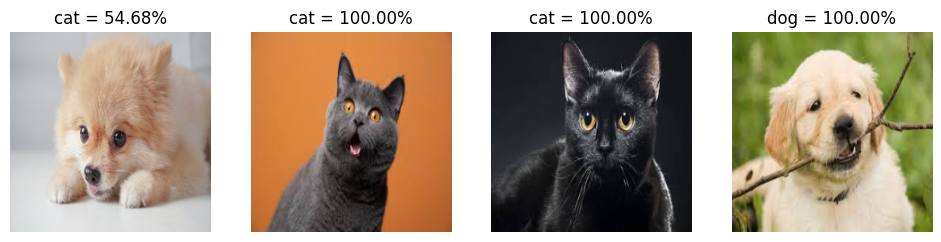

In [34]:
plt.figure(figsize=(15,10))

for i in range(len(pred)):
  if pred[i] > 0.5:
    prob = pred[i]
    prediction = "dog"

  else:
    prob = 1 - pred[i]
    prediction = "cat"

  plt.subplot(1, 5, i+1)
  plt.axis('off')
  plt.imshow(test_img_list[i])
  prob_str=str("{0:0.2f}".format(100*max(prob)))+ "%"
  plt.title(prediction + " = " + prob_str)

오답노트

In [50]:
test_img_label_name_list = []

a = glob.glob("/content/test_img/*")

label_class = {'cat':0, "dog":1}

for i in a:
  test_img_label_name_list.append(label_class[i.split("/")[-1].split("_")[0]])

In [55]:
origin_label = np.array(test_img_label_name_list)

In [37]:
ret_val = model.predict(np.array(test_img_list))

1/1 [==============================] - 0s 44ms/step


In [39]:
pred_val = np.argmax(ret_val, axis=1)
pred_val

array([0, 0, 0, 0])

In [56]:
pred_comp_val =  np.equal(pred_val, origin_label)
pred_comp_val

array([False,  True,  True, False])

(-0.5, 223.5, 223.5, -0.5)

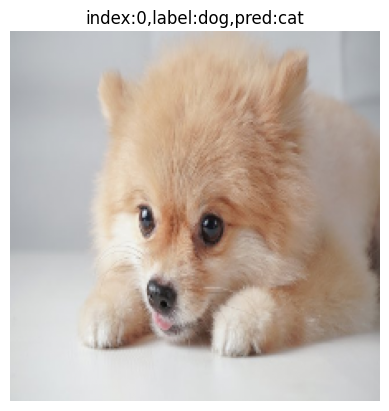

In [60]:
index_label_pred_list = [[idx, origin_label[idx], pred_val[idx]] for idx, result in enumerate(pred_comp_val) if result == False]

false_data_index = np.random.randint(len(index_label_pred_list))

index = index_label_pred_list[false_data_index][0]    # 인덱스
label = index_label_pred_list[false_data_index][1]          # 정답
pred = index_label_pred_list[false_data_index][2]

img = test_img_list[index]

class_ = {0: 'cat', 1:'dog'}

title = "index:" + str(index) + "," + "label:" + class_[label] + "," + "pred:" + class_[pred]
plt.imshow(img)
plt.title(title)
plt.axis("off")